In [1]:
from lsst.sims.featureScheduler.modelObservatory import Model_observatory
import numpy as np
from lsst.sims.almanac import Almanac
from lsst.sims.cloudModel import CloudData
%matplotlib inline
import matplotlib.pylab as plt
from scipy.stats import binned_statistic
from astropy.time import Time

from datetime import datetime

from lsst.sims.downtimeModel import ScheduledDowntimeData, UnscheduledDowntimeData


In [2]:
mjd_start=59853.5
cloud_limit=0.3
mjd_start_time = Time(mjd_start, format='mjd')

almanac = Almanac(mjd_start=mjd_start)
cloud_data = CloudData(mjd_start_time, offset_year=0)

In [3]:
mjds = np.arange(mjd_start, mjd_start+365.25*10, 1/24/10.)
times = Time(mjds, format='mjd')

bulk_cloud = [cloud_data(time) for time in times]


In [4]:
#plt.plot(mjds, bulk_cloud, 'ko')

In [5]:
sun_moon_info = almanac.get_sun_moon_positions(mjds)
good = np.where(sun_moon_info['sun_alt'] < np.radians(-18.))[0]

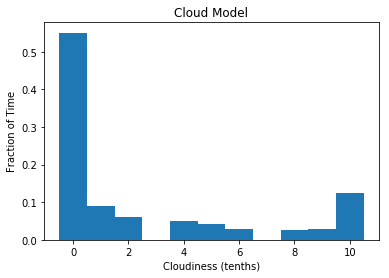

In [6]:
_temp = plt.hist(np.array(bulk_cloud)[good]*10, bins=np.arange(-.05, 1.15, .1)*10,
                 density=True)
plt.xlabel('Cloudiness (tenths)')
plt.ylabel('Fraction of Time')
plt.title('Cloud Model')
plt.savefig('cloud_levels.pdf')

In [7]:
print('Fraction of time we set as clouded out', np.where(np.array(bulk_cloud)[good] > cloud_limit)[0].size/good.size)

Fraction of time we set as clouded out 0.298292893913822


In [8]:
good = np.where((sun_moon_info['sun_alt'] < np.radians(-18.)) & (np.array(bulk_cloud) < cloud_limit))[0]
sun_down = np.where((sun_moon_info['sun_alt'] < np.radians(-18.)))[0]

almanac_indx = almanac.mjd_indx(mjds)
nights = almanac.sunsets['night'][almanac_indx]

In [9]:
times = np.ones(np.size(good))*(mjds[1]-mjds[0])*24
all_times = np.ones(np.size(sun_down))*(mjds[1]-mjds[0])*24

In [10]:
n = nights[good] % 365
# fudge the bins because there's something weird going on at the start I don't want to bother wth
bins = np.arange(5., 366, 1)
hours_available, be, bi = binned_statistic(n, times, bins=bins, statistic=np.sum)

all_hours_possible, be, bi = binned_statistic((nights[sun_down] % 365), all_times,
                                              bins=bins, statistic=np.sum)

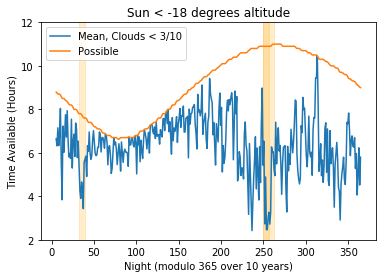

In [11]:
night_binned = (be[1:]+be[:-1])/2
plt.plot(night_binned, hours_available/10., label='Mean, Clouds < 3/10')
plt.plot(night_binned, all_hours_possible/10., label='Possible')
plt.xlabel('Night (modulo 365 over 10 years)')
plt.ylabel('Time Available (Hours)')
plt.title('Sun < -18 degrees altitude')
plt.legend()

sched_dts = [[33,40], [249,256], [249,263]]
for dt in sched_dts:
    plt.fill_between(dt, [0,0], y2=[15,15], alpha=.2, color='orange')
plt.ylim([2,12])
plt.savefig('hours_pernight.pdf')

In [12]:
# Let's also plot up the scheduled and unscheduled downtime


In [13]:
mjd_start_time = Time(mjd_start, format='mjd')
# Downtime
down_nights = []
sched_downtime_data = ScheduledDowntimeData(mjd_start_time)
unsched_downtime_data = UnscheduledDowntimeData(mjd_start_time)

sched_downtimes = sched_downtime_data()
unsched_downtimes = unsched_downtime_data()

down_starts = []
down_ends = []
for dt in sched_downtimes:
    down_starts.append(dt['start'].mjd)
    down_ends.append(dt['end'].mjd)
for dt in unsched_downtimes:
    down_starts.append(dt['start'].mjd)
    down_ends.append(dt['end'].mjd)

downtimes = np.array(list(zip(down_starts, down_ends)), dtype=list(zip(['start', 'end'], [float, float])))
downtimes.sort(order='start')

# Make sure there aren't any overlapping downtimes
diff = downtimes['start'][1:] - downtimes['end'][0:-1]
while np.min(diff) < 0:
    # Should be able to do this wihtout a loop, but this works
    for i, dt in enumerate(downtimes[0:-1]):
        if downtimes['start'][i+1] < dt['end']:
            new_end = np.max([dt['end'], downtimes['end'][i+1]])
            downtimes[i]['end'] = new_end
            downtimes[i+1]['end'] = new_end

    good = np.where(downtimes['end'] - np.roll(downtimes['end'], 1) != 0)
    downtimes = downtimes[good]
    diff = downtimes['start'][1:] - downtimes['end'][0:-1]


In [14]:
sched_list = [np.arange(slice['start'].mjd, slice['end'].mjd+1, 1) for slice in sched_downtimes]
unsched_list = [np.arange(slice['start'].mjd, slice['end'].mjd+1, 1) for slice in unsched_downtimes]

alldown = [np.arange(slice[0], slice[1]+1, 1) for slice in downtimes]


In [15]:
sched = np.concatenate(sched_list)
unsched = np.concatenate(unsched_list)
alldown = np.concatenate(alldown)

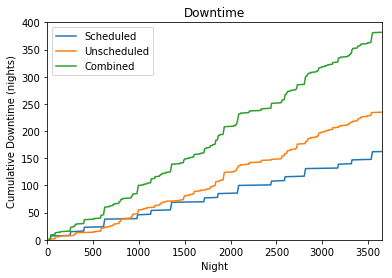

In [16]:
almanac_indx = almanac.mjd_indx(sched)
nights = almanac.sunsets['night'][almanac_indx]
good=np.where(nights >= 0 )

lost =np.arange(0, np.size(sched[good]), 1)
plt.plot(nights[good], lost, label='Scheduled')


almanac_indx = almanac.mjd_indx(unsched)
nights = almanac.sunsets['night'][almanac_indx]
good=np.where(nights >= 0 )

lost =np.arange(0, np.size(unsched[good]), 1)
plt.plot(nights[good], lost, label='Unscheduled')


almanac_indx = almanac.mjd_indx(alldown)
nights = almanac.sunsets['night'][almanac_indx]
good=np.where(nights >= 0 )

lost =np.arange(0, np.size(alldown[good]), 1)
plt.plot(nights[good], lost, label='Combined')


plt.xlim([0,3652])
plt.xlabel('Night')
plt.ylabel('Cumulative Downtime (nights)')
plt.legend(loc='upper left')
plt.ylim([0,400])
plt.title('Downtime')
plt.savefig('downtimes.pdf')

In [17]:
almanac_indx = almanac.mjd_indx(sched)
nights = almanac.sunsets['night'][almanac_indx]
nights = nights[np.where(nights > 0)]
nights % 365

array([ 33,  34,  35,  36,  37,  38,  39,  40, 249, 250, 251, 252, 253,
       254, 255, 256,  33,  34,  35,  36,  37,  38,  39,  40, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       249, 250, 251, 252, 253, 254, 255, 256,  33,  34,  35,  36,  37,
        38,  39,  40, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 249, 250, 251, 252, 253, 254, 255, 256,
        33,  34,  35,  36,  37,  38,  39,  40, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 249, 250, 251,
       252, 253, 254, 255, 256,  33,  34,  35,  36,  37,  38,  39,  40,
       249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261,
       262, 263, 249, 250, 251, 252, 253, 254, 255, 256,  33,  34,  35,
        36,  37,  38,  39,  40, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 249, 250, 251, 252, 253, 254,
       255, 256,  33,  34,  35,  36,  37,  38,  39,  40, 249, 25